In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression 
# from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRanker

In [2]:
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [4]:
# todo: la liste des rankers

# Objective

The purpose of this notebook is to build a model able to predict final rank based on the performances up to
leg N. 

From the EDA, the idea is to build a Linear Model where the feature is the leg up to leg N and another one for the remaining legs. We will use scikit-learn but also a variant based on PyTorch.

Once we get a linear model for every team-season, we can use all the corresponding parameters as inputs for a final model. 

In [5]:
def rolling_mean_n_performance(df, window=5, performance_col='goals_scored'):
    dg = df.sort_values(by=['leg'])[['season', 'team', performance_col]].groupby(
        by=['season', 'team'])[performance_col].rolling(window=window).mean().reset_index()
    
    new_col_name = f'rolling_{window}_games_avg_{performance_col}'

    df[new_col_name] = dg.set_index('level_2')[performance_col]
    return df

def get_past_feature(df, feat_col, team=True):
    merge_col = 'team' if team else 'opponent'    
    tmp_df = deepcopy(df[['season', 'leg', merge_col, feat_col]])
    tmp_df.loc[:,'next_leg'] = tmp_df['leg'] +1

    tmp_df.rename(columns={'leg': 'previous_leg', 
                           'next_leg':'leg', 
                           feat_col:f'previous_{merge_col}_{feat_col}'},
                  inplace=True)

    df = df.merge(tmp_df, how='left', on=['leg', 'season', merge_col])
    df.drop(columns=['previous_leg'], inplace=True)
    # print(f"length df : {len(df)}")
    return df

In [6]:
def prepare_data(csv_path, rolling=5):
    df = pd.read_csv(csv_path).drop(columns='Unnamed: 0')
    df['goal_diff'] = df['goals_scored'] - df['goals_conceded']
    # cumulative
    df['cum_pts'] = df[['season', 'team', 'nb_points']].groupby(
    by=['season', 'team']).cumsum()
    
    df['cum_goal_diff'] = df[['season', 'team', 'goal_diff']].groupby(
    by=['season', 'team']).cumsum()
    
    df['cum_goals_scored'] = df[['season', 'team', 'goals_scored']].groupby(
    by=['season', 'team']).cumsum()
    
    df['cum_goals_conceded'] = df['cum_goals_scored']-df['cum_goal_diff']
    df['rank'] = df[['season', 'leg', 'cum_pts', 'cum_goal_diff', 'cum_goals_scored']].sort_values(
        by=['cum_pts', 'cum_goal_diff', 'cum_goals_scored'], ascending=False).groupby(
        by=['season', 'leg']).cumcount() + 1
    
    df['avg_goals_scored_since_season_start'] = df['cum_goals_scored'].div(df['leg'])
    df['avg_goals_conceded_since_season_start'] = df['cum_goals_conceded'].div(df['leg'])
    df['avg_cum_pts_since_season_start'] = df['cum_pts'].div(df['leg'])
    
    # removed unwanted useless seasons
    data = deepcopy(df[df.season > '2003-2004'])
    data.reset_index(drop=True, inplace=True)
    
    leg_max = data.leg.max()
    
    end_season = data[data.leg==leg_max].rename(columns={'rank':'final_rank', 'cum_pts': 'final_cum_pts'})
    data = data.merge(end_season[['season', 'team', 'final_rank', 'final_cum_pts']], on=['season', 'team'])
    
    # rolling mean
    cols = ['goals_conceded', 'goals_scored', 'nb_points']
    for c in cols:
        data = rolling_mean_n_performance(df=data, window=rolling, performance_col=c)
    # past features
    past_features = {'rank': [True, False], 
                     'rolling_5_games_avg_goals_scored' : [True],
                     'rolling_5_games_avg_goals_conceded': [False],
                     'avg_goals_scored_since_season_start': [True],
                     'avg_goals_conceded_since_season_start': [False],
                     'goals_scored': [True],
                     'goals_conceded': [False],
                     'rolling_5_games_avg_nb_points': [True, False],
                     'nb_points': [True, False]
                    }
    # print(f'length {len(data)}')
    for col, is_team_ll in past_features.items():
        for is_team in is_team_ll:
            # print(f"is_team ={is_team}, col = {col}")
            data = get_past_feature(df=data, feat_col=col, team=is_team)
    
    return data

In [7]:
championship_csv = {'ligue-1': 'ligue-1_data_2002_2019',
                   'ligue-2': 'ligue-2_data_2002_2019',
                   'serie-A': 'serie-a_data_2004_2019',
                   'bundesliga': 'bundesliga_data_2004_2019',
                   'premier-league': 'premier-league_data_2004_2019',
                   'liga':'liga_data_2004_2019'}

In [8]:
l1_break_point = 27

In [161]:
ligue1_df = prepare_data(csv_path=championship_csv['liga'])# ['ligue-1'])

In [162]:
ligue1_df.head()

,country,season,leg,team,play,goals_scored,opponent,goals_conceded,nb_points,goal_diff,...,previous_team_rolling_5_games_avg_goals_scored,previous_opponent_rolling_5_games_avg_goals_conceded,previous_team_avg_goals_scored_since_season_start,previous_opponent_avg_goals_conceded_since_season_start,previous_team_goals_scored,previous_opponent_goals_conceded,previous_team_rolling_5_games_avg_nb_points,previous_opponent_rolling_5_games_avg_nb_points,previous_team_nb_points,previous_opponent_nb_points
0,Spain,2004-2005,1,Real Sociedad,Home,0,FC Barcelone,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Spain,2004-2005,2,Real Sociedad,Away,0,Villarreal,0,1,0,...,NaN,NaN,0.000000,4.000000,0.0,4.0,NaN,NaN,1.0,0.0
2,Spain,2004-2005,3,Real Sociedad,Away,1,Valence CF,3,0,-2,...,NaN,NaN,0.000000,2.000000,0.0,2.0,NaN,NaN,1.0,1.0
3,Spain,2004-2005,4,Real Sociedad,Home,0,Santander,1,0,-1,...,NaN,NaN,0.333333,0.666667,1.0,1.0,NaN,NaN,0.0,1.0
4,Spain,2004-2005,5,Real Sociedad,Away,1,Séville FC,2,0,-1,...,NaN,NaN,0.250000,0.500000,0.0,0.0,NaN,NaN,0.0,1.0


In [12]:
#all_championship_df = pd.concat([prepare_data(csv_path=path) for path in championship_csv.values()],
#                                axis=0, 
#                                ignore_index=True)

In [13]:
championship_dict_df = {champ: prepare_data(csv_path=path) for champ, path in championship_csv.items()}

In [14]:
def get_lr_parameters(data: pd.DataFrame):
    tmp_x_data = data.leg.values
    tmp_y_data = data.cum_pts.values
    
    x_data = np.array([0] + list(tmp_x_data)).reshape(-1, 1)
    y_data = np.array([0] + list(tmp_y_data)).reshape(-1, 1)
    
    reg = LinearRegression(fit_intercept=False).fit(X=x_data, y=y_data)
    
    return reg.coef_[0][0] , reg.score(X=x_data, y=y_data)

def get_season_team_data(break_leg: int, data: pd.DataFrame):
    """
    break_leg : split the season in two parts at this leg
    data: contains the season pts evolution wrt to legs for 1 team and 1 season
    
    returns: the Linear Regression parameters for both parts
    """
    data = data.reset_index(drop=True)
    
    breaking_cum_goal_diff = data.loc[break_leg-1, 'cum_goal_diff']
    breaking_cum_goal_scored = data.loc[break_leg-1, 'cum_goals_scored']
    roll_trend = data.loc[break_leg-1, 'rolling_5_games_avg_nb_points']
    trend = data.loc[break_leg-1,'avg_cum_pts_since_season_start']
    
    train_data = deepcopy(data[data.leg <= break_leg])
    eval_data = deepcopy(data[data.leg > break_leg])
    
    pts_at_break = data.loc[break_leg-1, 'cum_pts']
    eval_data.cum_pts -= pts_at_break
    eval_data.leg -= break_leg
    
    coef_feat, r_score_feat = get_lr_parameters(data=train_data)
    coef_predict, r_score_predict = get_lr_parameters(data=eval_data) if len(eval_data) > 0 else (-10, -10)
    
    final_nb_pts = data.loc[len(data)-1, 'cum_pts']
    
    nb_games_at_home = len(eval_data[eval_data.play=='Home'])
    
    return [nb_games_at_home, coef_feat, coef_predict, pts_at_break, final_nb_pts, 
            r_score_feat, r_score_predict, breaking_cum_goal_diff, breaking_cum_goal_scored,
            roll_trend, trend]

In [15]:
def build_data(historical_data: pd.DataFrame, break_leg: int):
    season_team_all = historical_data[['season', 'team']].values
    data_for_model = []
    ids_data = []
    # season_value = {s : i for i, s in enumerate(np.sort(df.season.unique()), start=1)}
    for season_team in np.unique(['###'.join(ll) for ll in season_team_all]):
        season, team = season_team.split("###")
        
        evol_feat = get_season_team_data(
            break_leg=break_leg, 
            data=deepcopy(historical_data[(historical_data.season==season) & (historical_data.team==team)]
                         )
        )
        data_for_model.append(evol_feat) # [season_value[season]]+evol_feat)
        ids_data.append([season, team])
    
    data_df = pd.DataFrame(columns=['nb_games_to_play_at_home',
                                    'lr_feat_coeff', 'lr_predict_coeff',
                                    'nb_pts_at_break', 'final_nb_pts', 
                                    'r_score_feat', 'r_score_predict', 
                                    'cumulative_goal_diff_at_break', 
                                    'cumulative_goal_scored_at_break', 
                                    'rolling_5_avg_pts_at_break', 
                                    'season_trend_at_break'
                                    ], 
                             data=np.array(data_for_model)
                            )
    
    ids_df = pd.DataFrame(columns=['season', 'team'], data=np.array(ids_data))

    return pd.concat([ids_df, data_df], axis=1)
    
    

In [89]:
def get_pivoted(data: pd.DataFrame, break_leg: int, value_col: str = 'cum_pts'):
    
    df = deepcopy(data[data.leg <= break_leg])
    df.rolling_5_games_avg_nb_points = [y if x!=x else x for x, y in 
           zip(df.rolling_5_games_avg_nb_points, df.avg_cum_pts_since_season_start)]
    
    df_pivot = df.pivot_table(index=['season', 'team'], 
                              columns='leg', 
                              values=[value_col]).reset_index()
    
    df_pivot.columns = [f'leg_{l}' if l!='' else n for n, l in df_pivot.columns]
    
    final = df[['season', 'team', 'final_rank', 'final_cum_pts']].drop_duplicates()
    df_last_leg = df[df.leg==break_leg][['season', 
                                         'team', 
                                         'rank', 
                                         'rolling_5_games_avg_nb_points', 
                                         'avg_cum_pts_since_season_start', 
                                         'cum_pts', 
                                         'cum_goal_diff', 
                                         'cum_goals_scored']].reset_index(drop=True)
    
    
    df_pivot = df_pivot.merge(df_last_leg, on=['season', 'team'])
    
    return df_pivot.merge(final, on=['season', 'team'])

In [17]:
data_for_model = build_data(historical_data=ligue1_df, break_leg=l1_break_point)

In [18]:
data_for_model.head()

,season,team,nb_games_to_play_at_home,lr_feat_coeff,lr_predict_coeff,nb_pts_at_break,final_nb_pts,r_score_feat,r_score_predict,cumulative_goal_diff_at_break,cumulative_goal_scored_at_break,rolling_5_avg_pts_at_break,season_trend_at_break
0,2004-2005,Arminia Bielefeld,4.0,1.286291,0.821429,34.0,39.0,0.977300,0.862032,-7.0,32.0,1.2,1.259259
1,2004-2005,Bayer Leverkusen,4.0,1.600289,1.900000,43.0,57.0,0.986126,0.969872,15.0,50.0,1.0,1.592593
2,2004-2005,Bayern Munich,3.0,2.020779,3.000000,56.0,77.0,0.995330,1.000000,27.0,53.0,2.4,2.074074
3,2004-2005,Bochum,3.0,0.944589,1.607143,25.0,37.0,0.897794,0.817857,-18.0,36.0,0.8,0.925926
4,2004-2005,Borussia Dortmund,4.0,1.419625,2.300000,41.0,58.0,0.977630,0.985345,-1.0,35.0,2.0,1.518519


In [19]:
# get_pivoted(data=ligue1_df, break_leg=l1_break_point)

In [20]:
# data_for_model.r_score_predict.mean()

In [21]:
# data_for_model.r_score_feat.mean()

In [22]:
# plt.scatter(data=data_for_model, x='lr_feat_coeff', y='lr_predict_coeff') #  , c='season')

In [23]:
# plt.scatter(data=data_for_model, x='nb_pts_at_break', y='final_nb_pts')

In [24]:
# data_for_model[['nb_pts_at_break', 'final_nb_pts']].corr()

In [25]:
# data_for_model[['lr_feat_coeff', 'lr_predict_coeff']].corr()

In [26]:
# data_for_model[['lr_feat_coeff', 'final_nb_pts']].corr()

In [36]:
# https://scikit-learn.org/stable/modules/preprocessing.html
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

def get_scaler(data: pd.DataFrame, cols, scaler_type='standard'):
    print(f"cols to rescale are :{cols}")
    if scaler_type=='min_max':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    scaler.fit(X=data[cols].values)
    
    return scaler

### EXTRACT A RANDOM VALIDATION SET

In [21]:
only_L1 = True

In [131]:
df = deepcopy(ligue1_df) if only_L1 else deepcopy(all_championship_df)

In [23]:
sorted_season = np.sort(ligue1_df.season.unique())

validate_season = np.random.choice(sorted_season, size=1, replace=False) # pick 3 out of 15

In [24]:
validate_season

array(['2011-2012'], dtype=object)

In [163]:
validation = deepcopy(df[df.season.isin(validate_season)]).reset_index(drop=True)
training = deepcopy(df[~df.season.isin(validate_season)]).reset_index(drop=True)

In [164]:
training_data_for_model = build_data(historical_data=training, break_leg=l1_break_point)
validation_data_for_model = build_data(historical_data=validation, break_leg=l1_break_point)

# Model Family A : Linear Regression

In [134]:
def fit_general_lr_model(data: pd.DataFrame, 
                         feature_cols, 
                         target_col, 
                         test_frac = .2, 
                         feat_scaler: StandardScaler or MinMaxScaler =None, 
                         target_scaler: StandardScaler or MinMaxScaler =None,
                         verbose=True):
    
    data.reset_index(drop=True, inplace=True)
    
    features = data[feature_cols].values
    target = data[target_col].values
    
    if feat_scaler:
        print("scale features")
        features = feat_scaler.transform(features)
        
    if target_scaler:
        print("scale target")
        target = target_scaler.transform(target.reshape(-1,1))
    
    # split data
    # print(f"features : {features[:3]}")
    # print(f"target : {target[:3]}")
    x_train, x_test, y_train, y_test = train_test_split(features, 
                                                        target,
                                                        test_size=test_frac,
                                                        random_state=42)
    
    lr_model = LinearRegression().fit(X=x_train, y=y_train)
    # print(f"coefs : {lr_model.coef_}, intercep : {lr_model.intercept_}")
    pred = lr_model.predict(x_test) 

    if verbose:
        # R2_score :
        r2_score_train = lr_model.score(X=x_train, y=y_train)
        print(f"R2_score_train : {r2_score_train}") 
        r2_score_test = lr_model.score(X=x_test, y=y_test)
        print(f"R2_score_test : {r2_score_test}") 

         # RMSE Computation 
        if target_scaler:
            y_test = target_scaler.inverse_transform(y_test)
            pred = target_scaler.inverse_transform(pred) 
        if feat_scaler:
            x_test = feat_scaler.inverse_transform(x_test)
        # print(f"x_test = {[f[0] for f in x_test[:3]]}")
        # print(f"y_test = {y_test[:3]}, pred = {pred[:3]}")
        rmse = np.sqrt(MSE(y_test, pred)) 
        print(f"RMSE on test : {rmse}") 
    
    return lr_model

In [135]:
def predict(scikit_model, 
            feature: np.array,
            feat_scaler: StandardScaler or MinMaxScaler=None, 
            target_scaler: StandardScaler or MinMaxScaler=None):
    
    feature = feature.reshape(1, -1)
    if feat_scaler:
        feature = feat_scaler.transform(feature)
        
    prediction = scikit_model.predict(feature)
    
    if target_scaler: 
        prediction = target_scaler.inverse_transform(prediction)
    
    return prediction[0]

In [136]:
## 1. Between nb_points at breaking leg vs final nb_points

In [137]:
model_lr_1 = fit_general_lr_model(
    data=training_data_for_model, 
    feature_cols=['nb_games_to_play_at_home','nb_pts_at_break'], 
    target_col='final_nb_pts')
overall_lr_1 = deepcopy(validation_data_for_model)
overall_lr_1['predicted_final_cum_pts'] = overall_lr_1[['nb_games_to_play_at_home','nb_pts_at_break']].apply(
    lambda x: model_lr_1.predict(np.array(x).reshape(1, -1))[0], axis=1)
rmse = np.sqrt(MSE(overall_lr_1.final_nb_pts.values, overall_lr_1.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

R2_score_train : 0.9227101754118535
R2_score_test : 0.9055449065695264
RMSE on test : 4.502273498238257
RMSE on validation : 4.519946167784453


In [138]:
## 2. Between lr_feat_coeff vs final nb_points

In [139]:
model_lr_2 = fit_general_lr_model(
    data=training_data_for_model, 
    feature_cols=['lr_feat_coeff'], 
    target_col='final_nb_pts')
overall_lr_2 = deepcopy(validation_data_for_model)
overall_lr_2['predicted_final_cum_pts'] = overall_lr_2[['lr_feat_coeff']].apply(
    lambda x: model_lr_2.predict(np.array(x).reshape(1, -1))[0], axis=1)
rmse = np.sqrt(MSE(overall_lr_2.final_nb_pts.values, overall_lr_2.predicted_final_cum_pts.values)) 
print(f"RMSE on validation: {rmse}") 

R2_score_train : 0.8875981447143237
R2_score_test : 0.8523238276341444
RMSE on test : 5.629559272622461
RMSE on validation: 5.361183106986895


In [140]:
## 3. Between nb_points at break leg + lr_feat_coeff vs final nb_points

In [141]:
init_feat_cols= ['lr_feat_coeff', 'nb_pts_at_break']
extra_cols = ['cumulative_goal_diff_at_break', 'rolling_5_avg_pts_at_break']

In [142]:
feature_cols = init_feat_cols + extra_cols +['nb_games_to_play_at_home']
feat_scaler = get_scaler(data=training_data_for_model, cols=feature_cols, scaler_type='min_max')  # 'standard')
target_scaler = get_scaler(data=training_data_for_model, 
                           cols=['final_nb_pts'], 
                           scaler_type='min_max')  # 'standard')

cols to rescale are :['lr_feat_coeff', 'nb_pts_at_break', 'cumulative_goal_diff_at_break', 'rolling_5_avg_pts_at_break', 'nb_games_to_play_at_home']
cols to rescale are :['final_nb_pts']


In [143]:
model = fit_general_lr_model(data=training_data_for_model, 
                             feature_cols=feature_cols, 
                             target_col='final_nb_pts',
                             feat_scaler=feat_scaler, 
                             target_scaler=target_scaler)
overall = deepcopy(validation_data_for_model)
overall['predicted_final_cum_pts'] = overall[feature_cols].apply(
    lambda x: predict(scikit_model=model, 
                      feature=np.array(x), 
                      feat_scaler=feat_scaler, 
                      target_scaler=target_scaler), 
    axis=1)
rmse = np.sqrt(MSE(overall.final_nb_pts.values, overall.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

scale features
scale target
R2_score_train : 0.9275893084496678
R2_score_test : 0.9115095808833882
RMSE on test : 4.357800139792316
RMSE on validation : 4.16940043645245


In [144]:
feat_cols_basic = init_feat_cols + extra_cols
no_scaler_model_lr_3 = fit_general_lr_model(
    data=training_data_for_model, 
    feature_cols=feat_cols_basic, 
    target_col='final_nb_pts',
    feat_scaler=None, 
    target_scaler=None)
overall_lr_3 = deepcopy(validation_data_for_model)
overall_lr_3['predicted_final_cum_pts'] = overall_lr_3[feat_cols_basic].apply(
    lambda x: predict(scikit_model=no_scaler_model_lr_3, 
                      feature=np.array(x), 
                      feat_scaler=None, 
                      target_scaler=None), 
    axis=1)
rmse = np.sqrt(MSE(overall_lr_3.final_nb_pts.values, overall_lr_3.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

R2_score_train : 0.9273776842865725
R2_score_test : 0.9118901636339777
RMSE on test : 4.348418951053689
RMSE on validation : 4.1394955638565945


In [145]:
def compute_expected_final_nb_points(lin_coeff, nb_pts_at_break, breaking_leg, final_leg, basic=True):
    # print(f'inputs are : lin_coeff={lin_coeff}, nb_pts_at_break={nb_pts_at_break}, breaking_leg={breaking_leg} and final_leg={final_leg}')
    # print(f"-- basic is {basic}")
    if basic:
      #  print(f'---- output is {lin_coeff*final_leg}')
        return lin_coeff*final_leg
    
    else:
        # print(f'---- output is {nb_pts_at_break + lin_coeff*(final_leg - breaking_leg)}')
        return nb_pts_at_break + lin_coeff*(final_leg - breaking_leg)

def lr_ranker(data_training, data_evaluation, feature_cols, 
              breaking_leg=27, final_leg=38, basic=True):
    cols = ['lr_feat_coeff', 'nb_pts_at_break']
    # fit the model
    if not basic:
        model = fit_general_lr_model(data=data_training, 
                                     feature_cols=feature_cols, 
                                     target_col='lr_predict_coeff',
                                     feat_scaler=None, 
                                     target_scaler=None,
                                    verbose=False)
        # get the predicted number of points
        data_evaluation['predicted_lr_predict_coeff'] = data_evaluation[feature_cols].apply(
            lambda x: predict(scikit_model=model, 
                              feature=np.array(x), 
                              feat_scaler=None, 
                              target_scaler=None),
            axis=1)

        cols = ['predicted_lr_predict_coeff', 'nb_pts_at_break']
        
    data_evaluation['predicted_final_cum_pts'] = data_evaluation[cols].apply(
        lambda r: compute_expected_final_nb_points(lin_coeff=r[0],
                                                   nb_pts_at_break=r[1],
                                                   breaking_leg=breaking_leg,
                                                   final_leg=final_leg, 
                                                   basic=basic), 
        axis=1)
    
    return data_evaluation

In [146]:
eval_final_1 = lr_ranker(data_training=training_data_for_model,
                       data_evaluation=validation_data_for_model,
                       feature_cols=feature_cols+['nb_games_to_play_at_home'],
                       breaking_leg=27,
                       final_leg=38,
                       basic=False)
rmse = np.sqrt(MSE(eval_final_1.final_nb_pts.values, eval_final_1.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

RMSE on validation : 4.259300232532567


In [147]:
#eval_final_1[['season', 'team', 'nb_pts_at_break', 'final_nb_pts', 'predicted_final_cum_pts']]

In [148]:
eval_final_2 = lr_ranker(data_training=training_data_for_model,
                       data_evaluation=validation_data_for_model,
                       feature_cols=feature_cols,
                       breaking_leg=27,
                       final_leg=38,
                       basic=True)
rmse = np.sqrt(MSE(eval_final_2.final_nb_pts.values, eval_final_2.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

RMSE on validation : 5.318145151214517


In [149]:
# eval_final_2[['season', 'team', 'nb_pts_at_break', 'final_nb_pts', 'predicted_final_cum_pts']]

In [150]:
## 4. Linear Regression on pivoted data...

In [151]:
training_pivoted = get_pivoted(data=training, break_leg=l1_break_point)
validation_pivoted = get_pivoted(data=validation, break_leg=l1_break_point)

In [152]:
feat_cols = [c for c in training_pivoted.columns if c.startswith('leg')]
feat_cols += ['rolling_5_games_avg_nb_points', 'avg_cum_pts_since_season_start', 
              'cum_goal_diff', 'cum_goals_scored']

target_col = 'final_cum_pts'

In [153]:
def lr_pts_predicter(data_training, data_evaluation, feature_cols, target_col):

    model = fit_general_lr_model(data=data_training, 
                                 feature_cols=feature_cols, 
                                 target_col=target_col,
                                 feat_scaler=None, 
                                 target_scaler=None,
                                verbose=False)
    # get the predicted number of points
    data_evaluation[f'predicted_{target_col}'] = data_evaluation[feature_cols].apply(
        lambda x: predict(scikit_model=model, 
                          feature=np.array(x), 
                          feat_scaler=None, 
                          target_scaler=None),
        axis=1)


    return data_evaluation

In [167]:
ligue1_df.groupby(by='season').count()

,country,leg,team,play,goals_scored,opponent,goals_conceded,nb_points,goal_diff,cum_pts,...,previous_team_rolling_5_games_avg_goals_scored,previous_opponent_rolling_5_games_avg_goals_conceded,previous_team_avg_goals_scored_since_season_start,previous_opponent_avg_goals_conceded_since_season_start,previous_team_goals_scored,previous_opponent_goals_conceded,previous_team_rolling_5_games_avg_nb_points,previous_opponent_rolling_5_games_avg_nb_points,previous_team_nb_points,previous_opponent_nb_points
season,,,,,,,,,,,,,,,,,,,,,
2004-2005,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2005-2006,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2006-2007,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2007-2008,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2008-2009,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2009-2010,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2010-2011,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2011-2012,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740
2012-2013,760,760,760,760,760,760,760,760,760,760,...,660,660,740,740,740,740,660,660,740,740


In [154]:
predicted_pts_df = lr_pts_predicter(data_training=deepcopy(training_pivoted), 
                                    data_evaluation=deepcopy(validation_pivoted),
                                    feature_cols=feat_cols, 
                                    target_col=target_col)
rmse = np.sqrt(MSE(predicted_pts_df.final_cum_pts.values, predicted_pts_df.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 
# predicted_pts_df[['season', 'team', 'predicted_final_cum_pts', 'final_cum_pts']]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [126]:
## 5. Linear Regression on pivoted data + lr_trends...

In [127]:
training_all_features = training_pivoted.merge(training_data_for_model[
    ['season', 'team', 'nb_games_to_play_at_home', 'lr_feat_coeff']], on=['season', 'team'])
validation_all_features = validation_pivoted.merge(validation_data_for_model[
    ['season', 'team', 'nb_games_to_play_at_home', 'lr_feat_coeff']], on=['season', 'team'])

In [128]:
predicted_pts_df_all = lr_pts_predicter(data_training=deepcopy(training_all_features), 
                                        data_evaluation=deepcopy(validation_all_features),
                                        feature_cols=feat_cols + ['nb_games_to_play_at_home', 'lr_feat_coeff'], 
                                        target_col=target_col)
rmse = np.sqrt(MSE(predicted_pts_df_all.final_cum_pts.values, 
                   predicted_pts_df_all.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 
# predicted_pts_df_all[['season', 'team', 'predicted_final_cum_pts', 'final_cum_pts']]

RMSE on validation : 5.645826591933714


# Model Family B : Random Forest Regressor // Xgboost Regressor-Ranker

## Random Forest

In [58]:
def fit_general_random_forest_model(data: pd.DataFrame, 
                                    feature_cols, 
                                    target_col, 
                                    test_frac = .2, 
                                    feat_scaler: StandardScaler or MinMaxScaler =None, 
                                    target_scaler: StandardScaler or MinMaxScaler =None,
                                    verbose=True):
    
    data.reset_index(drop=True, inplace=True)
    
    features = data[feature_cols].values
    target = data[target_col].values
    
    if feat_scaler:
        print("scale features")
        features = feat_scaler.transform(features)
        
    if target_scaler:
        print("scale target")
        target = target_scaler.transform(target.reshape(-1,1))
    
    # split data
    # print(f"features : {features[:3]}")
    # print(f"target : {target[:3]}")
    x_train, x_test, y_train, y_test = train_test_split(features, 
                                                        target,
                                                        test_size=test_frac,
                                                        random_state=42)
    
    rand_forest_model = RandomForestRegressor().fit(X=x_train, y=y_train)
    # print(f"coefs : {lr_model.coef_}, intercep : {lr_model.intercept_}")
    pred = rand_forest_model.predict(x_test) 

    if verbose:
        # R2_score :
        r2_score_train = rand_forest_model.score(X=x_train, y=y_train)
        print(f"R2_score_train : {r2_score_train}") 
        r2_score_test = rand_forest_model.score(X=x_test, y=y_test)
        print(f"R2_score_test : {r2_score_test}") 

         # RMSE Computation 
        if target_scaler:
            y_test = target_scaler.inverse_transform(y_test)
            pred = target_scaler.inverse_transform(pred) 
        if feat_scaler:
            x_test = feat_scaler.inverse_transform(x_test)
        # print(f"x_test = {[f[0] for f in x_test[:3]]}")
        # print(f"y_test = {y_test[:3]}, pred = {pred[:3]}")
        rmse = np.sqrt(MSE(y_test, pred)) 
        print(f"RMSE on test : {rmse}") 
    
    return rand_forest_model

def random_forest_pts_predicter(data_training, data_evaluation, feature_cols, target_col):

    model = fit_general_random_forest_model(data=data_training, 
                                            feature_cols=feature_cols, 
                                            target_col=target_col,
                                            feat_scaler=None, 
                                            target_scaler=None,
                                            verbose=False)
    # get the predicted number of points
    data_evaluation[f'predicted_{target_col}'] = data_evaluation[feature_cols].apply(
        lambda x: predict(scikit_model=model, 
                          feature=np.array(x), 
                          feat_scaler=None, 
                          target_scaler=None),
        axis=1)


    return data_evaluation

In [59]:

def rf_ranker(data_training, data_evaluation, feature_cols, 
              breaking_leg=27, final_leg=38):

    # fit the model
    model = fit_general_random_forest_model(
        data=data_training, 
        feature_cols=feature_cols, 
        target_col='lr_predict_coeff',
        feat_scaler=None, 
        target_scaler=None,
        verbose=False)
    # get the predicted number of points
    data_evaluation['predicted_rf_predict_coeff'] = data_evaluation[feature_cols].apply(
        lambda x: predict(scikit_model=model, 
                          feature=np.array(x), 
                          feat_scaler=None, 
                          target_scaler=None),
        axis=1)

    cols = ['predicted_rf_predict_coeff', 'nb_pts_at_break']
        
    data_evaluation['predicted_final_cum_pts'] = data_evaluation[cols].apply(
        lambda r: compute_expected_final_nb_points(lin_coeff=r[0],
                                                   nb_pts_at_break=r[1],
                                                   breaking_leg=breaking_leg,
                                                   final_leg=final_leg, 
                                                   basic=False), 
        axis=1)
    
    return data_evaluation

In [60]:
rand_forest_predicted_pts_df_all = random_forest_pts_predicter(
    data_training=deepcopy(training_all_features), 
    data_evaluation=deepcopy(validation_all_features),
    feature_cols=feat_cols + ['nb_games_to_play_at_home', 'lr_feat_coeff'], 
    target_col=target_col)

rmse = np.sqrt(MSE(rand_forest_predicted_pts_df_all.final_cum_pts.values, 
                   rand_forest_predicted_pts_df_all.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 
# rand_forest_predicted_pts_df_all[['season', 'team', 'predicted_final_cum_pts', 'final_cum_pts']]

RMSE on validation : 5.384720976986644


In [61]:
eval_final_rf = rf_ranker(
    data_training=training_data_for_model,
    data_evaluation=validation_data_for_model,
    feature_cols=feature_cols,
    breaking_leg=27,
    final_leg=38)

rmse = np.sqrt(MSE(eval_final_rf.final_nb_pts.values, eval_final_rf.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}")

RMSE on validation : 6.156516127791598


In [62]:
model_rf = fit_general_random_forest_model(
    data=training_data_for_model, 
    feature_cols=['nb_games_to_play_at_home', 'nb_pts_at_break'], 
    target_col='final_nb_pts')
overall_rf_1 = deepcopy(validation_data_for_model)
overall_rf_1['predicted_final_cum_pts'] = overall_rf_1[['nb_games_to_play_at_home','nb_pts_at_break']].apply(
    lambda x: model_rf.predict(np.array(x).reshape(1, -1))[0], axis=1)
rmse = np.sqrt(MSE(overall_rf_1.final_nb_pts.values, overall_rf_1.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

R2_score_train : 0.9371650222831378
R2_score_test : 0.7637642272129705
RMSE on test : 5.288872150372673
RMSE on validation : 5.471546997792614


In [63]:
model_rf_3 = fit_general_random_forest_model(
    data=deepcopy(training_data_for_model), 
    feature_cols=feat_cols_basic, 
    target_col='final_nb_pts')

overall_rf_3 = deepcopy(validation_data_for_model)
overall_rf_3['predicted_final_cum_pts'] = overall_rf_3[feat_cols_basic].apply(
    lambda x: predict(scikit_model=model_rf_3, 
                      feature=np.array(x), 
                      feat_scaler=None, 
                      target_scaler=None), 
    axis=1)
rmse = np.sqrt(MSE(overall_rf_3.final_nb_pts.values, overall_rf_3.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

R2_score_train : 0.9842056002265264
R2_score_test : 0.7165896473997313
RMSE on test : 5.792927492086486
RMSE on validation : 6.351071563130115


## XGBoost Regressor

In [64]:
def fit_general_xgb_model(data: pd.DataFrame, 
                                    feature_cols, 
                                    target_col, 
                                    test_frac = .2, 
                                    feat_scaler: StandardScaler or MinMaxScaler =None, 
                                    target_scaler: StandardScaler or MinMaxScaler =None,
                                    verbose=True):
    
    data.reset_index(drop=True, inplace=True)
    
    features = data[feature_cols].values
    target = data[target_col].values
    
    if feat_scaler:
        print("scale features")
        features = feat_scaler.transform(features)
        
    if target_scaler:
        print("scale target")
        target = target_scaler.transform(target.reshape(-1,1))
    
    # split data
    # print(f"features : {features[:3]}")
    # print(f"target : {target[:3]}")
    x_train, x_test, y_train, y_test = train_test_split(features, 
                                                        target,
                                                        test_size=test_frac,
                                                        random_state=42)
    
    xgb_model = XGBRegressor().fit(X=x_train, y=y_train)
    # print(f"coefs : {lr_model.coef_}, intercep : {lr_model.intercept_}")
    pred = xgb_model.predict(x_test) 

    if verbose:
        # R2_score :
        r2_score_train = xgb_model.score(X=x_train, y=y_train)
        print(f"R2_score_train : {r2_score_train}") 
        r2_score_test = xgb_model.score(X=x_test, y=y_test)
        print(f"R2_score_test : {r2_score_test}") 

         # RMSE Computation 
        if target_scaler:
            y_test = target_scaler.inverse_transform(y_test)
            pred = target_scaler.inverse_transform(pred) 
        if feat_scaler:
            x_test = feat_scaler.inverse_transform(x_test)
        # print(f"x_test = {[f[0] for f in x_test[:3]]}")
        # print(f"y_test = {y_test[:3]}, pred = {pred[:3]}")
        rmse = np.sqrt(MSE(y_test, pred)) 
        print(f"RMSE on test : {rmse}") 
    
    return xgb_model

def xgb_pts_predicter(data_training, data_evaluation, feature_cols, target_col):

    model = fit_general_xgb_model(
        data=data_training, 
        feature_cols=feature_cols, 
        target_col=target_col,
        feat_scaler=None, 
        target_scaler=None,
        verbose=False)
    # get the predicted number of points
    data_evaluation[f'predicted_{target_col}'] = data_evaluation[feature_cols].apply(
        lambda x: predict(scikit_model=model, 
                          feature=np.array(x), 
                          feat_scaler=None, 
                          target_scaler=None),
        axis=1)


    return data_evaluation

In [65]:

def xgb_ranker(data_training, data_evaluation, feature_cols, 
              breaking_leg=27, final_leg=38):

    # fit the model
    model = fit_general_xgb_model(
        data=data_training, 
        feature_cols=feature_cols, 
        target_col='lr_predict_coeff',
        feat_scaler=None, 
        target_scaler=None,
        verbose=False)
    # get the predicted number of points
    data_evaluation['predicted_xgb_predict_coeff'] = data_evaluation[feature_cols].apply(
        lambda x: predict(scikit_model=model, 
                          feature=np.array(x), 
                          feat_scaler=None, 
                          target_scaler=None),
        axis=1)

    cols = ['predicted_xgb_predict_coeff', 'nb_pts_at_break']
        
    data_evaluation['predicted_final_cum_pts'] = data_evaluation[cols].apply(
        lambda r: compute_expected_final_nb_points(lin_coeff=r[0],
                                                   nb_pts_at_break=r[1],
                                                   breaking_leg=breaking_leg,
                                                   final_leg=final_leg, 
                                                   basic=False), 
        axis=1)
    
    return data_evaluation

In [66]:
xgb_predicted_pts_df_all = xgb_pts_predicter(
    data_training=deepcopy(training_all_features), 
    data_evaluation=deepcopy(validation_all_features),
    feature_cols=feat_cols + ['nb_games_to_play_at_home', 'lr_feat_coeff'], 
    target_col=target_col)

rmse = np.sqrt(MSE(xgb_predicted_pts_df_all.final_cum_pts.values, 
                   xgb_predicted_pts_df_all.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 
# xgb_predicted_pts_df_all[['season', 'team', 'predicted_final_cum_pts', 'final_cum_pts']]

RMSE on validation : 5.441660693581815


In [67]:
eval_final_xgb = xgb_ranker(
    data_training=training_data_for_model,
    data_evaluation=validation_data_for_model,
    feature_cols=feature_cols,
    breaking_leg=27,
    final_leg=38)

rmse = np.sqrt(MSE(eval_final_xgb.final_nb_pts.values, eval_final_xgb.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}")

RMSE on validation : 7.090337392199805


In [68]:
model_xgb = fit_general_xgb_model(
    data=training_data_for_model, 
    feature_cols=['nb_games_to_play_at_home', 'nb_pts_at_break'], 
    target_col='final_nb_pts')
overall_xgb_1 = deepcopy(validation_data_for_model)
overall_xgb_1['predicted_final_cum_pts'] = overall_xgb_1[['nb_games_to_play_at_home','nb_pts_at_break']].apply(
    lambda x: model_xgb.predict(np.array(x).reshape(1, -1))[0], axis=1)
rmse = np.sqrt(MSE(overall_xgb_1.final_nb_pts.values, overall_xgb_1.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

R2_score_train : 0.9389061638084593
R2_score_test : 0.7465323519501026
RMSE on test : 5.478371822688063
RMSE on validation : 5.468314908940295


In [69]:
xgb_predicted_pts_df = xgb_pts_predicter(
    data_training=deepcopy(training_pivoted), 
    data_evaluation=deepcopy(validation_pivoted),
    feature_cols=feat_cols, 
    target_col=target_col)
rmse = np.sqrt(MSE(xgb_predicted_pts_df.final_cum_pts.values, 
                   xgb_predicted_pts_df.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 
# xgb_predicted_pts_df[['season', 'team', 'predicted_final_cum_pts', 'final_cum_pts']]

RMSE on validation : 5.43088889212451


In [70]:
model_xgb_3 = fit_general_xgb_model(
    data=deepcopy(training_data_for_model), 
    feature_cols=feat_cols_basic, 
    target_col='final_nb_pts')

overall_xgb_3 = deepcopy(validation_data_for_model)
overall_xgb_3['predicted_final_cum_pts'] = overall_xgb_3[feat_cols_basic].apply(
    lambda x: predict(scikit_model=model_xgb_3, 
                      feature=np.array(x), 
                      feat_scaler=None, 
                      target_scaler=None), 
    axis=1)
rmse = np.sqrt(MSE(overall_xgb_3.final_nb_pts.values, overall_xgb_3.predicted_final_cum_pts.values)) 
print(f"RMSE on validation : {rmse}") 

R2_score_train : 0.9999708965174571
R2_score_test : 0.6767666163751703
RMSE on test : 6.186547356092603
RMSE on validation : 7.40251834422887


# Predicted Points to Rank

In [71]:
def points_to_rank(season_data: pd.DataFrame, pts_col_name: str, rank_name: str):
    rank_df = season_data.sort_values(by=pts_col_name, ascending=False).reset_index(drop=True)
    rank_df[rank_name] = rank_df.index +1
    return rank_df

In [72]:
val_season = validate_season[0]

In [73]:
# linear regression : Between nb_points at breaking leg vs final nb_points
lr_1 = deepcopy(overall_lr_1[overall_lr_1.season==val_season])

# linear regression : Between lr_feat_coeff vs final nb_points
lr_2 = deepcopy(overall_lr_2[overall_lr_2.season==val_season])

# linear regression : Between nb_points at break leg + lr_feat_coeff vs final nb_points
lr_3 = deepcopy(overall_lr_3[overall_lr_3.season==val_season])

# linear regression ranker : not basic
lr_4 = deepcopy(eval_final_1[eval_final_1.season==val_season])

# linear regression ranker : basic
basic = deepcopy(eval_final_2[eval_final_2.season==val_season])

# linear Regression on pivoted data...
lr_5 = deepcopy(predicted_pts_df[predicted_pts_df.season==val_season])

# linear Regression on pivoted data + lr_trends...
lr_6 = deepcopy(predicted_pts_df_all[predicted_pts_df_all.season==val_season])

# random forest on pivoted data + lr_trends...
rf_1 = deepcopy(rand_forest_predicted_pts_df_all[rand_forest_predicted_pts_df_all.season==val_season])

# random forest ranker
rf_2 = deepcopy(eval_final_rf[eval_final_rf.season==val_season])

# random forest : nb_games_to_play_at_home, nb_pts_at_break vs final_nb_pts
rf_3 = deepcopy(overall_rf_1[overall_rf_1.season==val_season])

# random forest : Between nb_points at break leg + lr_feat_coeff vs final nb_points
rf_4 = deepcopy(overall_rf_3[overall_rf_3.season==val_season])

# xgboost on pivoted data + lr_trends...
xgb_1 = deepcopy(xgb_predicted_pts_df_all[xgb_predicted_pts_df_all.season==val_season])

# xgboost ranker
xgb_2 = deepcopy(eval_final_xgb[eval_final_xgb.season==val_season])

# xgboost : nb_games_to_play_at_home, nb_pts_at_break vs final_nb_pts
xgb_3 = deepcopy(overall_xgb_1[overall_xgb_1.season==val_season])

# xgboost : Between nb_points at break leg + lr_feat_coeff vs final nb_points
xgb_4 = deepcopy(overall_xgb_3[overall_xgb_3.season==val_season])



In [74]:
regression_rankers = {
    'lr_1' : lr_1,
    'lr_2' : lr_2,
    'lr_3' : lr_3,
    'lr_4' : lr_4,
    'lr_5' : lr_5,
    'lr_6' : lr_6,
    'basic' : basic,
    'rf_1' : rf_1,
    'rf_2' : rf_2,
    'rf_3' : rf_3,
    'rf_4' : rf_4,
    'xgb_1' : xgb_1,
    'xgb_2' : xgb_2,
    'xgb_3' : xgb_3,
    'xgb_4' : xgb_4
}

In [75]:
vote_casting_regression = {idx : list(getattr(points_to_rank(season_data=data, 
                                                             pts_col_name= 'predicted_final_cum_pts', 
                                                             rank_name='predicted_rank'
                                                            ), 'team'))
                          for idx, data in regression_rankers.items()
                          }

In [76]:
#tt = points_to_rank(season_data=rf_1, pts_col_name= 'predicted_final_cum_pts',rank_name='predicted_rank')
#tt[['team', 'final_rank', 'predicted_rank', 'predicted_final_cum_pts']]

# MODEL C : VIA CLUSTERS

Embed the path progression until leg N in $\mathbb{R}^{N}$. Then use cluster type algorithm to predict the final cluster (K-nearest neighbor + UMAP, DBSCAN). Tester pymde

Need to pivot dataframe such that columns are final_rank, the featuring legs and the identifier (couple season-team)

Fuzzy C-Means Clustering —Is it Better than K-Means Clustering?
https://towardsdatascience.com/fuzzy-c-means-clustering-is-it-better-than-k-means-clustering-448a0aba1ee7


In [77]:
ligue1_df.head()

,country,season,leg,team,play,goals_scored,opponent,goals_conceded,nb_points,goal_diff,...,previous_team_rolling_5_games_avg_goals_scored,previous_opponent_rolling_5_games_avg_goals_conceded,previous_team_avg_goals_scored_since_season_start,previous_opponent_avg_goals_conceded_since_season_start,previous_team_goals_scored,previous_opponent_goals_conceded,previous_team_rolling_5_games_avg_nb_points,previous_opponent_rolling_5_games_avg_nb_points,previous_team_nb_points,previous_opponent_nb_points
0,France,2004-2005,1,Lyon,Home,0,Nice,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,France,2004-2005,2,Lyon,Home,1,Sochaux,1,1,0,...,NaN,NaN,0.000000,1.000000,0.0,1.0,NaN,NaN,1.0,3.0
2,France,2004-2005,3,Lyon,Away,1,Metz,1,1,0,...,NaN,NaN,0.500000,1.500000,1.0,2.0,NaN,NaN,1.0,0.0
3,France,2004-2005,4,Lyon,Home,1,Lille,0,3,1,...,NaN,NaN,0.666667,1.333333,1.0,0.0,NaN,NaN,1.0,1.0
4,France,2004-2005,5,Lyon,Away,2,Rennes,1,3,1,...,NaN,NaN,0.750000,1.250000,1.0,1.0,NaN,NaN,3.0,1.0


In [78]:
ligue1_df.columns

Index(['country', 'season', 'leg', 'team', 'play', 'goals_scored', 'opponent',
       'goals_conceded', 'nb_points', 'goal_diff', 'cum_pts', 'cum_goal_diff',
       'cum_goals_scored', 'cum_goals_conceded', 'rank',
       'avg_goals_scored_since_season_start',
       'avg_goals_conceded_since_season_start',
       'avg_cum_pts_since_season_start', 'final_rank', 'final_cum_pts',
       'rolling_5_games_avg_goals_conceded',
       'rolling_5_games_avg_goals_scored', 'rolling_5_games_avg_nb_points',
       'previous_team_rank', 'previous_opponent_rank',
       'previous_team_rolling_5_games_avg_goals_scored',
       'previous_opponent_rolling_5_games_avg_goals_conceded',
       'previous_team_avg_goals_scored_since_season_start',
       'previous_opponent_avg_goals_conceded_since_season_start',
       'previous_team_goals_scored', 'previous_opponent_goals_conceded',
       'previous_team_rolling_5_games_avg_nb_points',
       'previous_opponent_rolling_5_games_avg_nb_points',
       'prev

In [79]:
only_L1 = True

In [80]:
df = deepcopy(ligue1_df) if only_L1 else deepcopy(all_championship_df)

In [81]:
df_0 = deepcopy(df[['season', 'team', 'cum_pts', 'cum_goal_diff', 'cum_goals_scored', 'leg', 'rank', 
                           'rolling_5_games_avg_nb_points', 'avg_cum_pts_since_season_start',
                           'final_rank', 'final_cum_pts']])
df_1 = deepcopy(df_0[df_0.leg <= l1_break_point]) 

In [82]:
# sorted_season = np.sort(df_1.season.unique())
# validate_season = np.random.choice(sorted_season, size=3, replace=False) # pick 3 out of 15

In [83]:
validation = deepcopy(df_1[df_1.season.isin(validate_season)]).reset_index(drop=True)
training = deepcopy(df_1[~df_1.season.isin(validate_season)]).reset_index(drop=True)

In [84]:
validate_season

array(['2006-2007'], dtype=object)

In [85]:
df.columns

Index(['country', 'season', 'leg', 'team', 'play', 'goals_scored', 'opponent',
       'goals_conceded', 'nb_points', 'goal_diff', 'cum_pts', 'cum_goal_diff',
       'cum_goals_scored', 'cum_goals_conceded', 'rank',
       'avg_goals_scored_since_season_start',
       'avg_goals_conceded_since_season_start',
       'avg_cum_pts_since_season_start', 'final_rank', 'final_cum_pts',
       'rolling_5_games_avg_goals_conceded',
       'rolling_5_games_avg_goals_scored', 'rolling_5_games_avg_nb_points',
       'previous_team_rank', 'previous_opponent_rank',
       'previous_team_rolling_5_games_avg_goals_scored',
       'previous_opponent_rolling_5_games_avg_goals_conceded',
       'previous_team_avg_goals_scored_since_season_start',
       'previous_opponent_avg_goals_conceded_since_season_start',
       'previous_team_goals_scored', 'previous_opponent_goals_conceded',
       'previous_team_rolling_5_games_avg_nb_points',
       'previous_opponent_rolling_5_games_avg_nb_points',
       'prev

In [86]:
train_pivoted_df = get_pivoted(data=training, break_leg=l1_break_point)
valid_pivoted_df = get_pivoted(data=validation, break_leg=l1_break_point)

In [87]:
# train_pivoted_df

In [88]:
feat_cols = [c for c in train_pivoted_df.columns if c not in ['season', 'team', 'final_rank', 'final_cum_pts']]

In [89]:
one_season_val = deepcopy(valid_pivoted_df[valid_pivoted_df.season==validate_season[-1]]).reset_index(
    drop=True)

## Cluster algorithm

In [90]:
def score_to_rank(season_df: pd.DataFrame, scores: np.array, col_name: str):
    tmp = pd.DataFrame(data=scores, columns=[col_name])

    output_df = pd.concat([season_df[['season', 'team', 'final_rank']], tmp], axis=1)

    output_df['predicted_rank'] = output_df[col_name].rank()
    return output_df

#### umap

In [91]:
from umap import UMAP

In [92]:
reducer = UMAP()

In [93]:
embedding_umap = reducer.fit_transform(train_pivoted_df[feat_cols].values)

In [94]:
embedding_umap_valid = reducer.transform(valid_pivoted_df[feat_cols].values)

In [95]:
one_season_umap_valid = reducer.transform(one_season_val[feat_cols].values)

In [96]:
show_valid = False

Text(0.5, 1.0, 'UMAP projection of the path progession till leg 27')

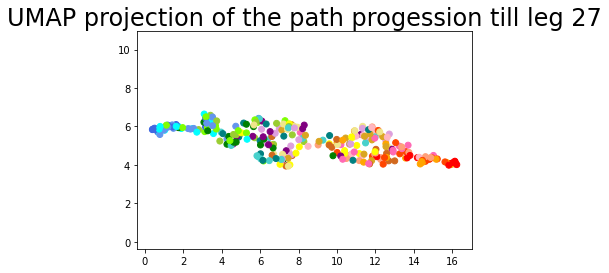

In [97]:
color_2_position = {1: "royalblue",
                   2: "aqua",
                   3: "cornflowerblue",
                   4: "chartreuse",
                   5: "yellowgreen",
                   6: "green",
                   7: "teal",
                   8: "purple",
                   9: "mediumturquoise",
                   10: "plum",
                   11: "khaki",
                   12: "goldenrod",
                   13: "yellow",
                   14: "chocolate",
                   15: "lightpink",
                   16: "hotpink",
                   17: "lightsalmon",
                   18: "orange",
                   19: "orangered",
                   20: "red"}

plt.scatter(
    embedding_umap[:, 0],
    embedding_umap[:, 1],
    c=[color_2_position[x] for x in train_pivoted_df.final_rank])
if show_valid:
    plt.scatter(
        embedding_umap_valid[:, 0],
        embedding_umap_valid[:, 1],
        c=[color_2_position[x] for x in valid_pivoted_df.final_rank],
        s=200
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP projection of the path progession till leg {l1_break_point}', fontsize=24)



In [98]:

#plt.scatter(
#    embedding_umap_valid[:, 0],
#    embedding_umap_valid[:, 1],
#    c=[color_2_position[x] for x in valid_pivoted_df.final_rank],
#    s=200
#)
#plt.gca().set_aspect('equal', 'datalim')
#plt.title(f'UMAP projection of the path progession till leg {l1_break_point} for valid data', fontsize=24)



Text(0.5, 1.0, 'UMAP projection of the path progession till leg 27')

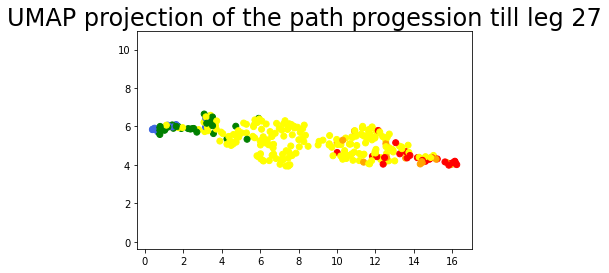

In [99]:
def rank_to_index(rk):
    if rk==1:
        return 1
    if rk < 4:
        return 6
    if 3<rk<18:
        return 13
    if rk==18:
        return 18
    return 20
plt.scatter(
    embedding_umap[:, 0],
    embedding_umap[:, 1],
    c=[color_2_position[rank_to_index(rk=x)] for x in train_pivoted_df.final_rank])
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP projection of the path progession till leg {l1_break_point}', fontsize=24)


In [100]:
tmp_df = deepcopy(train_pivoted_df[['season', 'team', 'final_rank']])

In [101]:
embed_colums = ["x_col_umap_embed", "y_col_umap_embed"]

In [102]:
embedding_df = pd.DataFrame(data=embedding_umap, columns=embed_colums)

In [103]:
embedding_df = pd.concat([tmp_df, embedding_df], axis=1)
embedding_df

,season,team,final_rank,x_col_umap_embed,y_col_umap_embed
0,2004-2005,AC Ajaccio,11,12.704496,4.894781
1,2004-2005,Auxerre,9,3.967790,5.706800
2,2004-2005,Bastia,19,14.600331,4.186458
3,2004-2005,Bordeaux,15,7.496443,4.657119
4,2004-2005,Caen,18,13.566409,4.355425
...,...,...,...,...,...
275,2018-2019,Reims,8,6.518362,5.732928
276,2018-2019,Rennes,10,7.784143,5.920881
277,2018-2019,Saint-Étienne,4,4.429923,5.263539
278,2018-2019,Strasbourg,11,5.677844,6.075554


In [104]:
embed_colums

['x_col_umap_embed', 'y_col_umap_embed']

In [105]:
embedding_df[['final_rank']+embed_colums].values.shape

(280, 3)

In [106]:
position_weights = np.array([r+np.exp(np.log(100)*r/20) for r in range(1, 21)])

In [107]:
position_weights

array([  2.25892541,   3.58489319,   4.99526231,   6.51188643,
         8.16227766,   9.98107171,  12.01187234,  14.30957344,
        16.94328235,  20.        ,  23.58925412,  27.84893192,
        32.95262315,  39.11886432,  46.6227766 ,  55.81071706,
        67.11872336,  81.09573445,  98.43282347, 120.        ])

In [108]:
def compute_umap_score(position_weight : np.array, 
                       historical_umap_pos: np.array,  
                       team_season_umap_pos: np.array):
    """
    historical_umap_pos : shape (N,3) where N = nb_teams x nb_seasons
    team_season_map : shape (2,)
    """
    score = 0
    dists = []
    final_ranks = historical_umap_pos.transpose()[0]
    for r in historical_umap_pos:
        dist = np.linalg.norm(r[1:]-team_season_umap_pos)
        dists.append(dist)
    
    dg = pd.DataFrame(data={'dists': dists, 'final_rank': final_ranks}).sort_values(
        by='dists').reset_index(drop=True).reset_index()
    dg['index'] += 1
    dg['weigth'] = 1/dg['index']
    return dg.final_rank.dot(dg.weigth) # score

In [109]:
scores = [compute_umap_score(position_weight=position_weights, 
                    historical_umap_pos=embedding_df[['final_rank']+embed_colums].values,
                    team_season_umap_pos=team_pos
                   ) for team_pos in one_season_umap_valid]
scores

[67.48399291703033,
 70.97741720873869,
 73.81552374205378,
 40.257388340300615,
 42.10312095017421,
 78.03694213214814,
 26.40044814746896,
 43.81129193127821,
 63.519245016201474,
 72.06386698915762,
 96.03413236913434,
 79.92348689273196,
 82.24280359985387,
 58.17840078829084,
 45.77761129706983,
 101.3410072475344,
 50.69862645725577,
 42.89335731708715,
 79.92156681245025,
 91.61508238451923]

In [110]:
output_00 = score_to_rank(season_df=one_season_val, 
                          scores=scores, 
                          col_name='fuzzy_umap')
output_00

,season,team,final_rank,fuzzy_umap,predicted_rank
0,2006-2007,Auxerre,6,67.483993,10.0
1,2006-2007,Bordeaux,9,70.977417,11.0
2,2006-2007,Le Mans,13,73.815524,13.0
3,2006-2007,Lens,8,40.257388,2.0
4,2006-2007,Lille,12,42.103121,3.0
5,2006-2007,Lorient,14,78.036942,14.0
6,2006-2007,Lyon,1,26.400448,1.0
7,2006-2007,Marseille,2,43.811292,5.0
8,2006-2007,Monaco,7,63.519245,9.0
9,2006-2007,Nancy,15,72.063867,12.0


## Fuzzy C-'Nearest Neighbor'

In [111]:
# from fcmeans import FCM

In [112]:
# fcm = FCM(n_clusters=20)

In [113]:
# fcm.fit(embedding_umap)

In [114]:
# validate_season

In [115]:
one_season_umap_valid[0].shape

(2,)

A modifier : la prédiction retourne le numéro de cluster et non le rang comme souhaité. Toutefois, l'approche
fuzzy est la bonne voie.

In [116]:
cols = ['prob_rank_{k}'.format(k=k) for k in range(1, 21)]

In [118]:
#pd.concat([deepcopy(one_season_val[['season', 'team', 'final_rank']]),
#          predictions_df], axis=1 )

## Xgboost Classifier

In [119]:
from xgboost import XGBClassifier, XGBRFClassifier

In [120]:
cols = ['prob_rank_{k}'.format(k=k) for k in range(1, 21)]

#### after the embedding with UMAP

In [121]:
classifier_1 = XGBClassifier()
classifier_2 = XGBRFClassifier()

In [122]:
classifier_1.fit(X=embedding_df[embed_colums].values, y=embedding_df['final_rank'].values, 
                 eval_metric='mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
classifier_2.fit(X=embedding_df[embed_colums].values, y=embedding_df['final_rank'].values, 
                 eval_metric='mlogloss')

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [124]:
# classifier_1.predict(one_season_umap_valid)

In [125]:
probs = classifier_1.predict_proba(one_season_umap_valid)
# probs

In [126]:
weights = np.array([r+np.exp(np.log(100)*r/20) for r in range(1, 21)])

In [127]:
evaluation_1 = np.array([np.dot(probs[i], weights) for i in range(len(probs))])
# evaluation_1

In [128]:
output_01 = score_to_rank(season_df=one_season_val, 
                          scores=evaluation_1, 
                          col_name='xgb_classifier_umap')

In [129]:
# output_01

In [130]:
# classifier_2.predict(one_season_umap_valid)

In [131]:
probs_2 = classifier_2.predict_proba(one_season_umap_valid)

In [132]:
evaluation_2 = np.array([np.dot(probs_2[i], weights) for i in range(len(probs))])
#evaluation_2

In [133]:
output_02 = score_to_rank(season_df=one_season_val, 
                          scores=evaluation_2, 
                          col_name='xgbrf_classifier_umap')
#output_02

#### Without the embedding with UMAP

In [134]:
classifier_1_no_umap = XGBClassifier()
classifier_2_no_umap = XGBRFClassifier()

In [135]:
classifier_1_no_umap.fit(X=train_pivoted_df[feat_cols].values, y=train_pivoted_df['final_rank'].values, 
                 eval_metric='mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [136]:
classifier_2_no_umap.fit(X=train_pivoted_df[feat_cols].values, y=train_pivoted_df['final_rank'].values, 
                 eval_metric='mlogloss')

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [137]:
#classifier_1_no_umap.predict(one_season_val[feat_cols].values)

In [138]:
probs_no_umap_1 = classifier_1_no_umap.predict_proba(one_season_val[feat_cols].values)

In [139]:
evaluation_no_umap_1 = np.array([np.dot(probs_no_umap_1[i], weights) for i in range(len(probs))])
#evaluation_no_umap_1

In [140]:
output_11 = score_to_rank(season_df=one_season_val, 
                          scores=evaluation_no_umap_1, 
                          col_name='xgb_classifier_no_umap')
#output_11

In [141]:
#classifier_2_no_umap.predict(one_season_val[feat_cols].values)

In [142]:
probs_no_umap_2 = classifier_2_no_umap.predict_proba(one_season_val[feat_cols].values)

In [143]:
evaluation_no_umap_2 = np.array([np.dot(probs_no_umap_2[i], weights) for i in range(len(probs))])
#evaluation_no_umap_2

In [144]:
output_12 = score_to_rank(season_df=one_season_val, 
                          scores=evaluation_no_umap_2, 
                          col_name='xgbrf_classifier_no_umap')
#output_12

## XGBoost Ranker

In [145]:
from xgboost import XGBRanker

In [146]:
ranker = XGBRanker()

In [147]:
ranker_2 = XGBRanker()

In [148]:
group=np.array([20]*(15-len(validate_season)))

#### After embedding with UMAP

In [149]:
embedding_df_sorted = embedding_df.sort_values(by='season').reset_index(drop=True)

In [150]:
# embedding_df_sorted

In [151]:
ranker.fit(X=embedding_df_sorted[embed_colums].values, 
           y=embedding_df_sorted['final_rank'].values,
           group=group)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.300000012, max_delta_step=0, max_depth=6,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
#ranker.learning_rate

In [153]:
# ranker.predict(np.array([one_season_umap_valid[0]]))
# the lower the better
ranker_vals = ranker.predict(one_season_umap_valid)

In [154]:
tmp = pd.DataFrame(data=ranker_vals, columns=['xgb_ranker_umaped'])

In [155]:
output_df = pd.concat([one_season_val[['season', 'team', 'final_rank']], tmp], axis=1)

In [156]:
output_df['predicted_rank'] = output_df['xgb_ranker_umaped'].rank()

In [157]:
#output_df

#### without UMAP embedding

In [158]:
train_pivoted_df_sorted = train_pivoted_df.sort_values(by='season').reset_index(drop=True)

In [159]:
ranker_2.fit(X=train_pivoted_df_sorted[feat_cols].values, 
           y=train_pivoted_df_sorted['final_rank'].values,
           group=group)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.300000012, max_delta_step=0, max_depth=6,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method='exact', validate_parameters=1, verbosity=None)

In [160]:
# ranker.predict(np.array([one_season_umap_valid[0]]))
# the lower the better
ranker_vals_2 = ranker_2.predict(one_season_val[feat_cols].values)

In [161]:
tmp_2 = pd.DataFrame(data=ranker_vals_2, columns=['xgb_ranker_no_umaped'])

In [162]:
output_no_umap_df = pd.concat([one_season_val[['season', 'team', 'final_rank']], tmp_2], axis=1)
output_no_umap_df['predicted_rank'] = output_no_umap_df['xgb_ranker_no_umaped'].rank()
#output_no_umap_df

In [163]:
output_no_umap_df.sort_values(by='predicted_rank').reset_index(drop=True).team

0              Lyon
1             Lille
2         Marseille
3              Lens
4          Toulouse
5     Saint-Étienne
6           Sochaux
7            Monaco
8            Rennes
9           Auxerre
10             Nice
11         Bordeaux
12          Lorient
13           Troyes
14          Le Mans
15     Valenciennes
16            Nancy
17         Paris-SG
18           Nantes
19            Sedan
Name: team, dtype: object

# Clustering, Classification, Direct Ranker voters

In [164]:
ccdr_voters = {
    'fuzzy_umap': output_00.sort_values(by='predicted_rank').reset_index(drop=True),
    'xgb_class_umap': output_01.sort_values(by='predicted_rank').reset_index(drop=True),
    'xgbrf_class_umap': output_02.sort_values(by='predicted_rank').reset_index(drop=True),
    'xgb_class_no_umap': output_11.sort_values(by='predicted_rank').reset_index(drop=True), 
    'xgbrf_class_no_umap': output_12.sort_values(by='predicted_rank').reset_index(drop=True),
    'xgb_ranker_umap': output_df.sort_values(by='predicted_rank').reset_index(drop=True),
    'xgb_ranker_no_umap': output_no_umap_df.sort_values(by='predicted_rank').reset_index(drop=True)
              }

In [165]:
vote_casting_ccdr = {idx : getattr(data, 'team') for idx, data in ccdr_voters.items()}

# Rankers vote

In [166]:
RANKING = {'ranker_1': ['A', 'B', 'C', 'D', 'E'],
           'ranker_2': ['A', 'E', 'D', 'B', 'C'],
           'ranker_3': ['C', 'E', 'B', 'A', 'D'],
           'ranker_4': ['D', 'C', 'B', 'E', 'A']
          }

In [167]:
voters = {**vote_casting_regression, **vote_casting_ccdr}

In [168]:
# voters

In [169]:
pd.DataFrame(data={'team': voters['lr_1'], 'predicted_rank': list(range(1,21))})

,team,predicted_rank
0,Lyon,1
1,Toulouse,2
2,Lens,3
3,Sochaux,4
4,Marseille,5
5,Lille,6
6,Saint-Étienne,7
7,Monaco,8
8,Bordeaux,9
9,Rennes,10


In [170]:
# We build a Markov Chain based on all rankers : every rankers is voting

def rank_to_transition_mat(ranking, matrix, team_to_idx):
    for j in range(len(ranking)-1):
        fro = team_to_idx[ranking[j+1]]
        to = team_to_idx[ranking[j]]
        matrix[to][fro] += 1
    return matrix


def get_self_loop(matrix):
    for i in range(matrix.shape[0]):
        matrix[i][i] = matrix[i].sum()

    return matrix


def normalize(matrix: np.array):
    matrix_t = matrix.transpose()
    for i in range(matrix.shape[0]):
        matrix_t[i] = matrix_t[i] / (matrix_t[i].sum())

    return matrix_t.transpose()


def get_transition_matrix(team_to_idx, rankers=None):
    if rankers is None:
        raise ValueError("I Need voters: no voter, not transition matrix")
    
    nb_teams = len(team_to_idx)
    mat = np.zeros(nb_teams**2).reshape(nb_teams, nb_teams)
    for ranking in rankers.values():
        
        mat = rank_to_transition_mat(ranking=ranking,
                                     matrix=mat,
                                     team_to_idx=team_to_idx
                                     )
    mat = get_self_loop(matrix=mat)
    mat = normalize(matrix=mat)
    return mat


def get_invariant_probability(matrix, num_iterations: int = 100, d: float = .85):
    """PageRank: The trillion dollar algorithm.

    Parameters
    ----------
    matrix : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i',
        such that for all 'j' sum(i, M_i,j) = 1. The matrix is irreducible
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        the vector of invariant probability
        v sums to 1

    """
    n = matrix.shape[1]
    # v = np.random.rand(N, 1)
    inv_prb = np.ones((n, 1))
    inv_prb = inv_prb / np.linalg.norm(inv_prb, 1)
    matrix_hat = (d * matrix + (1 - d) / n)
    for i in range(num_iterations):
        inv_prb = matrix_hat @ inv_prb
    return inv_prb


def rankers_vote(rankers: dict, teams: list):
    # replace below ['A', 'B', 'C', 'D', 'E'] by teams
    team_to_idx = {p_id: i for i, p_id in enumerate(teams)} 
    idx_to_team = {i: p_id for i, p_id in enumerate(teams)}

    trans_mat = get_transition_matrix(team_to_idx=team_to_idx,
                                      rankers=rankers)

    v = get_invariant_probability(matrix=trans_mat, num_iterations=10, d=.95)
    
    voting_results = {idx_to_team[i] : v[i][0] for i in range(len(teams))}
    
    df = pd.DataFrame(data={"team": list(voting_results.keys()), "score": list(voting_results.values())})
    df.sort_values(by='score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['markov_voters_predicted_rank'] = df.index + 1
    return df

In [171]:
markov_voters = rankers_vote(rankers=voters, teams=list(validation.team.unique()))
markov_voters

,team,score,markov_voters_predicted_rank
0,Lyon,0.240578,1
1,Lens,0.049922,2
2,Toulouse,0.049895,3
3,Lille,0.049704,4
4,Saint-Étienne,0.049580,5
5,Sochaux,0.049563,6
6,Marseille,0.049191,7
7,Monaco,0.048822,8
8,Rennes,0.048605,9
9,Auxerre,0.046837,10


In [172]:
validate_season

array(['2006-2007'], dtype=object)

# RANK IMPORTANCE

In [ ]:
sdsd

In [173]:
gains = {1: 120, 2: 75, 3: 85, 4: 84}
bonus_position = {1: 300, 2: 280, 3: 270, 4: 260, 5: 220}

In [174]:
nb_teams = 20

In [175]:
gains[nb_teams] = 80
gains[nb_teams - 1] = 102
gains[nb_teams - 2] = 100
gains[nb_teams - 3] = 78

bonus_position[nb_teams] = 350
bonus_position[nb_teams - 1] = 340
bonus_position[nb_teams - 2] = 300
bonus_position[nb_teams - 3] = 280

In [303]:
for rk in range(5, nb_teams-3):
    gains[rk] = 60 - 2*rk
    
for rk in range(6, nb_teams-3):
    upper = ((nb_teams/2)-3)**2
    lower = ((nb_teams/2)-5)**2
    if 2*rk<nb_teams:
        bonus_position[rk] = int(220*(rk-nb_teams/2)**2/lower) 
    else:
        bonus_position[rk] = int(280*((rk-nb_teams/2)**2)/upper)

In [304]:
gains

{1: 120,
 2: 75,
 3: 85,
 4: 84,
 20: 80,
 19: 102,
 18: 100,
 17: 78,
 5: 50,
 6: 48,
 7: 46,
 8: 44,
 9: 42,
 10: 40,
 11: 38,
 12: 36,
 13: 34,
 14: 32,
 15: 30,
 16: 28}

In [305]:
validation

,season,team,cum_pts,cum_goal_diff,cum_goals_scored,leg,rank,rolling_5_games_avg_nb_points,avg_cum_pts_since_season_start,final_rank,final_cum_pts
0,2006-2007,Lyon,3,2,3,1,2,NaN,3.000000,1,81
1,2006-2007,Lyon,4,2,4,2,4,NaN,2.000000,1,81
2,2006-2007,Lyon,7,3,6,3,2,NaN,2.333333,1,81
3,2006-2007,Lyon,10,6,10,4,2,NaN,2.500000,1,81
4,2006-2007,Lyon,13,8,12,5,2,2.6,2.600000,1,81
...,...,...,...,...,...,...,...,...,...,...,...
535,2006-2007,Le Mans,29,1,29,23,14,1.4,1.260870,13,47
536,2006-2007,Le Mans,32,2,32,24,11,2.0,1.333333,13,47
537,2006-2007,Le Mans,32,0,32,25,12,1.4,1.280000,13,47
538,2006-2007,Le Mans,32,-2,32,26,13,1.2,1.230769,13,47


In [306]:
base_val = deepcopy(validation)[
    ['season', 'team', 'final_rank', 'final_cum_pts']].drop_duplicates().reset_index(drop=True)

In [307]:
base_val['base_gain'] = base_val['final_rank'].apply(lambda r: gains[r])
base_val['base_gain_2'] = base_val[['final_rank', 'final_cum_pts']].apply(
    lambda r: bonus_position[r[0]]+r[1], axis=1)

In [308]:
deepcopy(base_val).sort_values(by='base_gain_2', ascending=False).reset_index(drop=True)

,season,team,final_rank,final_cum_pts,base_gain,base_gain_2
0,2006-2007,Nice,16,44,28,249
1,2006-2007,Valenciennes,18,42,100,242
2,2006-2007,Lyon,1,81,120,231
3,2006-2007,Nantes,19,35,102,215
4,2006-2007,Sedan,20,34,80,214
5,2006-2007,Auxerre,6,56,48,196
6,2006-2007,Nancy,15,46,30,188
7,2006-2007,Marseille,2,66,75,186
8,2006-2007,Toulouse,3,59,85,159
9,2006-2007,Troyes,17,42,78,142


In [309]:
base_val['inv_discount'] = base_val['base_gain'].rank(ascending=False)
base_val.sort_values(by='base_gain_2', ascending=False, inplace=True)
base_val.reset_index(drop=True, inplace=True)
base_val['inv_discount_2'] = base_val.index + 1

In [310]:
base_val['gain'] = base_val[['base_gain', 'inv_discount']].apply(lambda r: r[0]/np.log2(1+r[1]), axis=1)
base_val['gain_2'] = base_val[['base_gain_2', 'inv_discount_2']].apply(lambda r: r[0]/np.log2(1+r[1]), axis=1)

In [311]:
base_val.sort_values(by='base_gain_2', ascending=False).reset_index(drop=True)

,season,team,final_rank,final_cum_pts,base_gain,base_gain_2,inv_discount,inv_discount_2,gain,gain_2
0,2006-2007,Nice,16,44,28,249,20.0,1,6.374767,249.000000
1,2006-2007,Valenciennes,18,42,100,242,3.0,2,50.000000,152.685000
2,2006-2007,Lyon,1,81,120,231,1.0,3,120.000000,115.500000
3,2006-2007,Nantes,19,35,102,215,2.0,4,64.354835,92.595460
4,2006-2007,Sedan,20,34,80,214,6.0,5,28.496575,82.786501
5,2006-2007,Auxerre,6,56,48,196,10.0,6,13.875112,69.816609
6,2006-2007,Nancy,15,46,30,188,19.0,7,6.941346,62.666667
7,2006-2007,Marseille,2,66,75,186,8.0,8,23.659866,58.676467
8,2006-2007,Toulouse,3,59,85,159,4.0,9,36.607507,47.863769
9,2006-2007,Troyes,17,42,78,142,7.0,10,26.000000,41.047205


In [312]:
rank_to_inv_discount = {rk : inv_disc for rk, inv_disc in zip(base_val.final_rank, base_val.inv_discount)}

rank_to_inv_discount_2 = {rk : inv_disc for rk, inv_disc in zip(base_val.final_rank, base_val.inv_discount_2)}

In [313]:
rank_to_inv_discount_2

{16: 1,
 18: 2,
 1: 3,
 19: 4,
 20: 5,
 6: 6,
 15: 7,
 2: 8,
 3: 9,
 17: 10,
 4: 11,
 14: 12,
 7: 13,
 5: 14,
 13: 15,
 8: 16,
 12: 17,
 9: 18,
 11: 19,
 10: 20}

In [314]:
all_voters_dict = {**{"markov_voters": markov_voters[['team', 'markov_voters_predicted_rank']]},
                   **{model: pd.DataFrame(data={'team': data, f'{model}_predicted_rank': list(range(1,21))})
                     for model, data in voters.items()}
                  }

In [315]:
all_voters_dict_2 = {
    model : dg.merge(base_val[['team', 'base_gain']], on='team').rename(
        columns={'base_gain': f'base__{model}_gain'}) 
    for model, dg in all_voters_dict.items()
}

In [316]:
all_voters_dict_2_b = {
    model : dg.merge(base_val[['team', 'base_gain_2']], on='team').rename(
        columns={'base_gain_2': f'base__{model}_gain_2'}) 
    for model, dg in all_voters_dict.items()
}

In [317]:
all_voters_dict_3 = dict()
all_voters_dict_3_b = dict()

In [318]:
for model, dg in all_voters_dict_2.items():
    dg[f'{model}_gain'] = dg[[f'base__{model}_gain', f'{model}_predicted_rank']].apply(
        lambda r: r[0]/np.log2(1+rank_to_inv_discount[r[1]]), axis=1)
    all_voters_dict_3[model] = dg[['team', f'{model}_predicted_rank', f'{model}_gain']]

In [319]:
for model, dg in all_voters_dict_2_b.items():
    dg[f'{model}_gain_2'] = dg[[f'base__{model}_gain_2', f'{model}_predicted_rank']].apply(
        lambda r: r[0]/np.log2(1+rank_to_inv_discount_2[r[1]]), axis=1)
    all_voters_dict_3_b[model] = dg[['team', f'{model}_predicted_rank', f'{model}_gain_2']]

In [320]:
quality_dcg_score = {model : getattr(dg, f'{model}_gain').sum() for model, dg in all_voters_dict_3.items()}

In [321]:
quality_dcg_score_B = {model : getattr(dg, f'{model}_gain_2').sum() 
                       for model, dg in all_voters_dict_3_b.items()}

In [322]:
quality_dcg_score

{'markov_voters': 492.32591470821825,
 'lr_1': 489.8976807475941,
 'lr_2': 481.57004416511757,
 'lr_3': 491.8945308452576,
 'lr_4': 491.216830531027,
 'lr_5': 491.87634113162693,
 'lr_6': 492.13820063876983,
 'basic': 491.216830531027,
 'rf_1': 492.99688429174364,
 'rf_2': 491.216830531027,
 'rf_3': 487.11029011702294,
 'rf_4': 492.1459706767404,
 'xgb_1': 490.7638734316108,
 'xgb_2': 491.216830531027,
 'xgb_3': 486.68430614975273,
 'xgb_4': 488.85369160255834,
 'fuzzy_umap': 490.9772645268973,
 'xgb_class_umap': 489.1678578160075,
 'xgbrf_class_umap': 493.46055413908783,
 'xgb_class_no_umap': 490.5831063401224,
 'xgbrf_class_no_umap': 496.3282591756693,
 'xgb_ranker_umap': 483.5262571129237,
 'xgb_ranker_no_umap': 474.77417338163826}

In [323]:
base_quality_score = base_val.gain.sum()
base_quality_score

503.8427280065789

In [324]:
quality_dcg_score_B

{'markov_voters': 1184.745202945828,
 'lr_1': 1180.7278223920462,
 'lr_2': 1111.83810899631,
 'lr_3': 1044.013637215624,
 'lr_4': 1103.6168526367903,
 'lr_5': 1134.6717571895624,
 'lr_6': 1140.0785934680102,
 'basic': 1103.6168526367903,
 'rf_1': 1188.3181167044443,
 'rf_2': 1103.6168526367903,
 'rf_3': 1115.2948072732456,
 'rf_4': 1100.038467380819,
 'xgb_1': 1187.7385102476924,
 'xgb_2': 1103.6168526367903,
 'xgb_3': 1115.7166595301817,
 'xgb_4': 1035.149960924697,
 'fuzzy_umap': 1176.363728102496,
 'xgb_class_umap': 1115.8830599224434,
 'xgbrf_class_umap': 1142.121817447353,
 'xgb_class_no_umap': 1097.9771138594092,
 'xgbrf_class_no_umap': 1100.867940359906,
 'xgb_ranker_umap': 1019.5714360930288,
 'xgb_ranker_no_umap': 1100.3864713835494}

In [325]:
base_quality_score_B = base_val.gain_2.sum()
base_quality_score_B

1214.79563861825

In [326]:
{model : round(100*score/base_quality_score,2) for model, score in quality_dcg_score.items()}

{'markov_voters': 97.71,
 'lr_1': 97.23,
 'lr_2': 95.58,
 'lr_3': 97.63,
 'lr_4': 97.49,
 'lr_5': 97.62,
 'lr_6': 97.68,
 'basic': 97.49,
 'rf_1': 97.85,
 'rf_2': 97.49,
 'rf_3': 96.68,
 'rf_4': 97.68,
 'xgb_1': 97.4,
 'xgb_2': 97.49,
 'xgb_3': 96.59,
 'xgb_4': 97.03,
 'fuzzy_umap': 97.45,
 'xgb_class_umap': 97.09,
 'xgbrf_class_umap': 97.94,
 'xgb_class_no_umap': 97.37,
 'xgbrf_class_no_umap': 98.51,
 'xgb_ranker_umap': 95.97,
 'xgb_ranker_no_umap': 94.23}

In [327]:
{model : round(100*score/base_quality_score_B,2) for model, score in quality_dcg_score_B.items()}

{'markov_voters': 97.53,
 'lr_1': 97.2,
 'lr_2': 91.52,
 'lr_3': 85.94,
 'lr_4': 90.85,
 'lr_5': 93.4,
 'lr_6': 93.85,
 'basic': 90.85,
 'rf_1': 97.82,
 'rf_2': 90.85,
 'rf_3': 91.81,
 'rf_4': 90.55,
 'xgb_1': 97.77,
 'xgb_2': 90.85,
 'xgb_3': 91.84,
 'xgb_4': 85.21,
 'fuzzy_umap': 96.84,
 'xgb_class_umap': 91.86,
 'xgbrf_class_umap': 94.02,
 'xgb_class_no_umap': 90.38,
 'xgbrf_class_no_umap': 90.62,
 'xgb_ranker_umap': 83.93,
 'xgb_ranker_no_umap': 90.58}

In [331]:
all_voters_dict_2['xgb_1'].merge(base_val[['team', 'final_rank', 'final_cum_pts']], on='team')

,team,xgb_1_predicted_rank,base__xgb_1_gain,xgb_1_gain,final_rank,final_cum_pts
0,Lyon,1,120,120.000000,1,81
1,Lens,2,44,13.880455,8,54
2,Toulouse,3,85,36.607507,3,59
3,Saint-Étienne,4,38,14.700407,11,49
4,Lille,5,36,10.837080,12,48
5,Monaco,6,46,13.296982,7,54
6,Auxerre,7,48,13.389261,6,56
7,Marseille,8,75,20.267862,2,66
8,Sochaux,9,50,13.132477,5,57
9,Rennes,10,84,21.500474,4,58


In [297]:
all_voters_dict['xgbrf_class_umap'].merge(base_val[['team', 'final_rank', 'final_cum_pts']], on='team')

,team,xgbrf_class_umap_predicted_rank,final_rank,final_cum_pts
0,Lyon,1,1,81
1,Lille,2,12,48
2,Toulouse,3,3,59
3,Lens,4,8,54
4,Marseille,5,2,66
5,Saint-Étienne,6,11,49
6,Monaco,7,7,54
7,Sochaux,8,5,57
8,Rennes,9,4,58
9,Le Mans,10,13,47
